# Ge - Visão Computacional
# Alunos: 
Leila Biggi e Lucas Heron

## Importações e úteis

In [13]:
import cv2, numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import warnings

In [2]:
def show_images(images, titles = None):
  n = len(images)
  plt.figure(figsize=(20, 10))
  for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(images[i])
    if titles is not None:
      plt.title(titles[i])
    plt.axis('off')
  plt.show()

## Pré-processamento

In [3]:
healthy = '../Test/Healthy/'
powdery = '../Test/Powdery/'
rust = '../Test/Rust/'


healthy_images = [(os.path.join(healthy, f), 0) for f in os.listdir(healthy) if f.endswith('.jpg')]
powdery_images = [(os.path.join(powdery, f), 1) for f in os.listdir(powdery) if f.endswith('.jpg')]
rust_images = [(os.path.join(rust, f), 2) for f in os.listdir(rust) if f.endswith('.jpg')]

all_images = healthy_images + powdery_images + rust_images

df = pd.DataFrame(all_images, columns=['image_path', 'label'])

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [4]:
df.to_csv('../Test/plant_disease.csv', index=False)

In [5]:
df.head()

,image_path,label
0,../Test/Powdery/84e59b911be64c6e.jpg,1
1,../Test/Healthy/8e97869f9e143863.jpg,0
2,../Test/Rust/86eec849f0b46976.jpg,2
3,../Test/Powdery/85e269f2ca36761c.jpg,1
4,../Test/Powdery/85b53e9c21a1f82f.jpg,1


In [6]:
healthy_img_example = cv2.imread(df['image_path'][1], cv2.IMREAD_COLOR_RGB)
powdery_img_example = cv2.imread(df['image_path'][0], cv2.IMREAD_COLOR_RGB)
rust_img_example = cv2.imread(df['image_path'][2], cv2.IMREAD_COLOR_RGB)

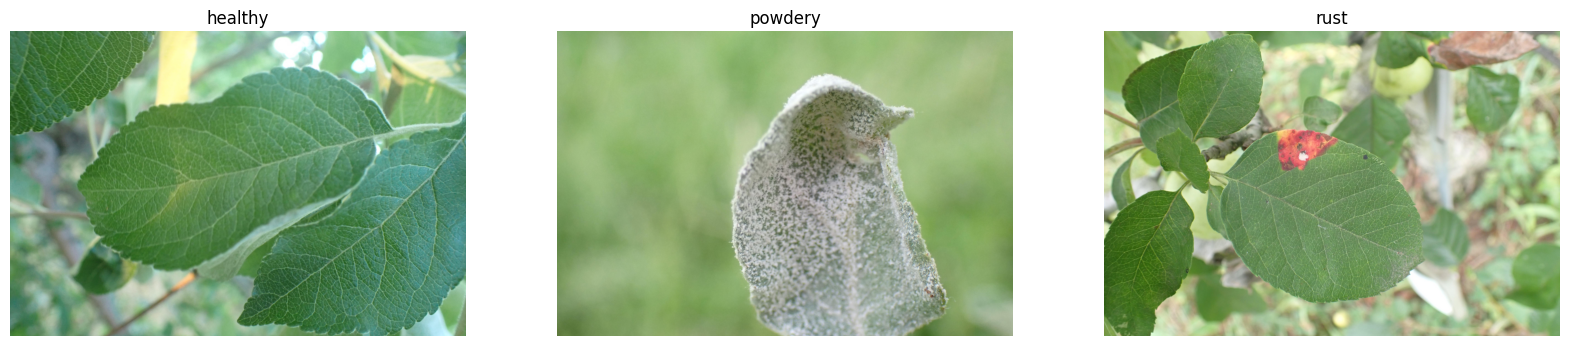

In [7]:
show_images([healthy_img_example, powdery_img_example, rust_img_example], ['healthy', 'powdery', 'rust'])

## Segmentação da imagem por cor

In [8]:
os.makedirs('../Test/total/', exist_ok=True)
for i in range(len(df)):
    img_path = df.iloc[i]['image_path']
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    
    # img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    image_name = os.path.basename(img_path)
    
    output_path = f'../Test/total/{image_name}'
    
    cv2.imwrite(output_path, img)

In [9]:
def color_segmentation(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    result = image.copy()
    
    lower_green = np.array([35, 40, 40])
    upper_green = np.array([85, 255, 255])
    green_mask = cv2.inRange(hsv, lower_green, upper_green)
    green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_OPEN, np.ones((5,5),np.uint8))
    
    lower_powdery = np.array([0, 0, 150])
    upper_powdery = np.array([180, 50, 255])
    powdery_mask = cv2.inRange(hsv, lower_powdery, upper_powdery)
    powdery_mask = cv2.morphologyEx(powdery_mask, cv2.MORPH_OPEN, np.ones((5,5),np.uint8))
    result[powdery_mask > 0] = [255, 0, 0]  
    
    # Melhor segmentação para rust (enferrujadas)
    lower_rust1 = np.array([5, 100, 80])   # laranja/vermelho
    upper_rust1 = np.array([25, 255, 255])
    lower_rust2 = np.array([160, 80, 80])  # vermelho escuro
    upper_rust2 = np.array([180, 255, 255])
    mask1 = cv2.inRange(hsv, lower_rust1, upper_rust1)
    mask2 = cv2.inRange(hsv, lower_rust2, upper_rust2)
    rust_mask = cv2.bitwise_or(mask1, mask2)
    rust_mask = cv2.morphologyEx(rust_mask, cv2.MORPH_OPEN, np.ones((5,5),np.uint8))
    rust_mask = cv2.morphologyEx(rust_mask, cv2.MORPH_CLOSE, np.ones((5,5),np.uint8))
    result[rust_mask > 0] = [0, 0, 255] 
    
    lower_dead = np.array([10, 50, 20])
    upper_dead = np.array([25, 255, 100])
    dead_mask = cv2.inRange(hsv, lower_dead, upper_dead)
    dead_mask = cv2.morphologyEx(dead_mask, cv2.MORPH_OPEN, np.ones((5,5),np.uint8))
    result[dead_mask > 0] = [0, 255, 255]
    
    return result

In [10]:
def extract_features(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    features = []
    # Média e desvio padrão dos canais HSV
    for i in range(3):
        features.append(np.mean(hsv[:,:,i]))
        features.append(np.std(hsv[:,:,i]))
    # Área das máscaras
    masks = []
    masks.append(cv2.inRange(hsv, np.array([35, 40, 40]), np.array([85, 255, 255]))) # green
    masks.append(cv2.inRange(hsv, np.array([0, 0, 150]), np.array([180, 50, 255]))) # powdery
    masks.append(cv2.bitwise_or(cv2.inRange(hsv, np.array([0, 50, 50]), np.array([15, 255, 255])),
                               cv2.inRange(hsv, np.array([160, 50, 50]), np.array([180, 255, 255])))) # rust
    for mask in masks:
        features.append(np.sum(mask > 0)) # área
    return features

In [11]:
os.makedirs('../Test/segmented/', exist_ok=True)
for i in range(len(df)):
    image_name = os.path.basename(df.iloc[i]['image_path'])
    
    img_path = f'../Test/total/{image_name}'
    
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    
    
    segmented_img = color_segmentation(img)

    output_path = f'../Test/segmented/{image_name}'

    cv2.imwrite(output_path, segmented_img)

In [14]:
warnings.filterwarnings('ignore')
X = []
y = []
for i in range(len(df)):
    img = cv2.imread(df.iloc[i]['image_path'])
    features = extract_features(img)
    X.append(features)
    y.append(df.iloc[i]['label'])
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy:.4f}")

# 2. Classification report
print(classification_report(y_test, y_pred))

# 3. Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, X, y, cv=cv)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"CV Mean Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Acurácia: 0.7667
              precision    recall  f1-score   support

           0       0.83      0.45      0.59        11
           1       0.83      0.91      0.87        11
           2       0.67      1.00      0.80         8

    accuracy                           0.77        30
   macro avg       0.78      0.79      0.75        30
weighted avg       0.79      0.77      0.75        30

Cross-Validation Scores: [0.83333333 0.8        0.73333333 0.66666667 0.76666667]
CV Mean Accuracy: 0.7600 (+/- 0.1147)
